# Trabajo práctico 3: forma y función en el universo Pokémon


Los enunciados del TP 3 son los siguientes:

1.   Usar el criterio de la Silueta para verificar que hay un máximo local cerca de k=8 clusters. Aplicar el algoritmo kmeans con k=8 clusters sobre los datos de *sprites* (matriz *data*).
2.   Visualizar las primeras dos componentes de la matriz de *sprites*, pintando con un color distinto los datos que pertenezcan a cada cluster, e indicando con cruces la posición de los centroides (ayuda: el código para hacer esto se encuentra en el notebook de clustering que vimos en clase).
3.   Visualizar los primeros 10 elementos de cada cluster. 
4.   En un mismo gráfico de barras, mostrar el valor promedio de los atributos *HP*, *Attack*, *Defense* y *Speed* de cada cluster. ¿Cuál es el cluster de Pokémones más fuertes?
5.   Hacer lo mismo que en el ítem anterior, pero con el tamaño promedio de los Pokémones por cluster (el tamaño se define como la cantidad de entradas no vacías en la fila correspondiente al *sprite* de ese Pokémon en la matriz data). ¿Son los Pokémones más grandes los más fuertes?
6.   Hacer gráficos de torta con la proporción de Pokémones legendarios/no legendarios por cluster. ¿Tiene el cluster de Pokémones más fuertes más legendarios que los otros? 

**Optativo**

7.   Entrenar, evaluar y determinar la performance de un modelo de aprendizaje supervisado para predecir alguna característica de los Pokémones en base a sus *sprites*. Puede ser, por ejemplo, un modelo de regresión (predecir *HP*, *Attack*, *Defense*, *Speed*), un modelo de clasificación binaria (legendario o no legendario), o un modelo de clasificación multiclase (tipo del Pokémon: tierra, hielo, agua, fuego, etc).


Cargamos los datos correspondientes a las imágenes

In [ ]:
from google.colab import drive
import pickle
import pandas as pd
import numpy as np

# Drive mount y directorio de imagenes
drive.mount('/content/drive', force_remount=True)
filename = '/content/drive/My Drive/LaboDatos_1C2022/LaboDatos2022/TerceraEjercitacion/pokemon_imagenes.p'

# Abrimos el archivo de imagenes y lo cargamos en un diccionario
with open(filename, 'rb') as file:
  data = pickle.load(file)

# Separo las listas de nombres y de imagenes
names = data['nombres']
imags = np.array(data['imagenes'])

# Veamos los tamaños
print(f'El tamaño de la lista de nombres es: {len(names)}')
print(f'El tamaño del array de imágenes es: {imags.shape}')

Mounted at /content/drive
El tamaño de la lista de nombres es: 698
El tamaño del array de imágenes es: (698, 56, 68)


Visualizamos 10 pokemones del conjunto de imágenes al azar.

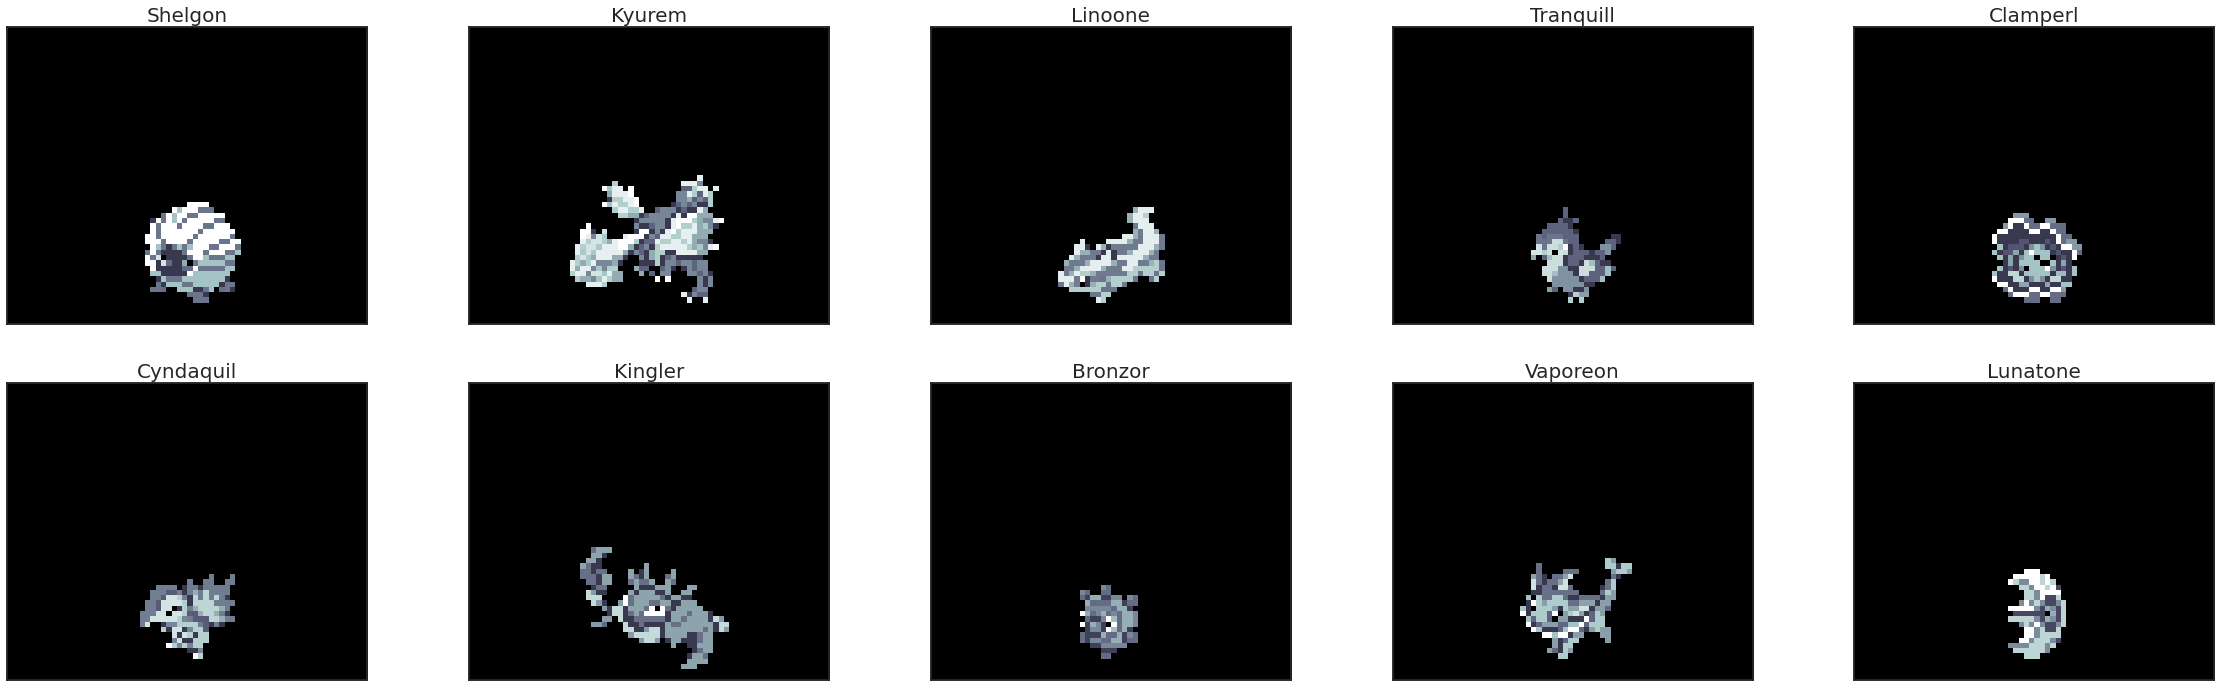

In [ ]:
import matplotlib.pyplot as plt

# Genero un objeto random para producir indices de manera aleatoria
rng = np.random.default_rng()

# Genero un subplot
fig, ax = plt.subplots(2, 5, figsize=(40, 12))

for i in range(5):
  idx_u = rng.integers(len(names))
  idx_l = rng.integers(len(names))  
  
  # Fila superior
  ax[0, i].imshow(imags[idx_u, :, :], cmap='bone')
  ax[0, i].set_title(names[idx_u].title(), size=20)
  ax[0, i].tick_params(left = False, right = False , 
                       labelleft = False , labelbottom = False, 
                       bottom = False)
  
  # Fila inferior
  ax[1, i].imshow(imags[idx_l, :, :], cmap='bone')
  ax[1, i].set_title(names[idx_l].title(), size=20)  
  ax[1, i].tick_params(left = False, right = False , 
                       labelleft = False , labelbottom = False, 
                       bottom = False)

Carguemos y visualicemos el DataFrame de atributos:

In [ ]:
attrs_file = '/content/drive/My Drive/LaboDatos_1C2022/LaboDatos2022/TerceraEjercitacion/pokemon_dataframe.csv'
df = pd.read_csv(attrs_file)
df.head()

,Unnamed: 0,level_0,index,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,0,0,0,1,bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,1,1,1,2,ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,2,2,2,3,venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,3,4,4,charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
4,4,4,5,5,charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False


Para poder trabajar con algoritmos de reducción de la dimensión y clustering,  primero tenemos que representar los datos de sprites como una matriz, para eso tenemos que "desenrollarlos" como vimos en clase:

In [ ]:
imags_unroll = imags.reshape((len(names), -1))
print(imags_unroll.shape)

(698, 3808)


Veamos en qué intervalo se encuentran los datos.

In [ ]:
print(f'Valor máximo posible de un pixel: {np.max(imags_unroll)}')
print(f'Valor mínimo posible de un pixel: {np.min(imags_unroll)}')

Valor máximo posible de un pixel: 255
Valor mínimo posible de un pixel: 0


Todos los pixeles toman valores entre 0 y 255, por lo que los "features" de nuestro conjunto se encuentran en el mismo rango, i.e. no hace falta normalizar.

Antes de hacer Clustering, hagamos PCA y veamos la varianza acumulada. Esto nos va a indicar si podemos hacer una reducción de dimensionalidad. 

Text(0, 0.5, 'Fracción de varianza acumulada')

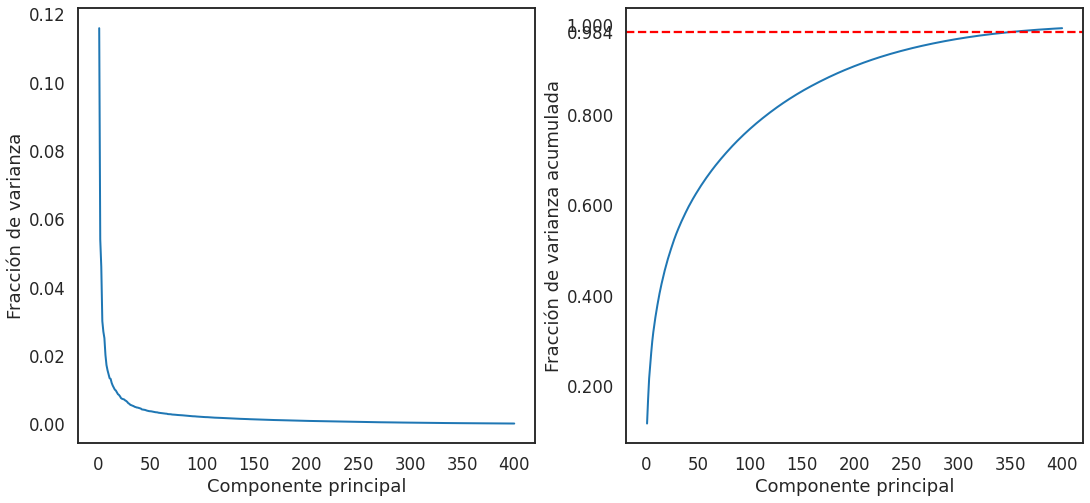

In [ ]:
from sklearn.decomposition import PCA

# Genero un objeto PCA y lo fiteo
pca = PCA(n_components=400)
pca.fit(imags_unroll)

# Extraemos la varianza explicada de cada componente
variance_ratio = pca.explained_variance_ratio_

# Ploteamos la variancia y la suma acumulada
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

ax[0].plot(range(1, 401), variance_ratio,
           linewidth=2)
ax[0].set_xlabel('Componente principal')
ax[0].set_ylabel('Fracción de varianza')

ax[1].plot(range(1, 401), np.cumsum(variance_ratio),
           linewidth=2)
ax[1].axhline(y=np.cumsum(variance_ratio)[-50], 
              color='r', linestyle='--')
lim = ax[1].get_ylim()
ax[1].set_yticks(list(ax[1].get_yticks()) + [np.cumsum(variance_ratio)[-50]])
ax[1].set_ylim(lim)
ax[1].set_xlabel('Componente principal')
ax[1].set_ylabel('Fracción de varianza acumulada')

Vemos que con las primeras 350 componentes explicamos el 98 % de la varianza. Tenemos alrededor de 3500 componentes que solo aportan el 2 % de la varianza. Podemos reducir perdiendo muy poca información.

In [ ]:
imags_pca = pca.transform(imags_unroll)

# 1. Silhouette method y K-Means



In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

silhouette_coef = list()

for k in range(2, 16):
  # Inicializo un objeto KMeans y lo fiteo
  k_means = KMeans(n_clusters=k, n_init=50)
  k_means.fit(imags_pca)

  # Guardo el score de silhouete
  score = silhouette_score(imags_pca, k_means.labels_)
  silhouette_coef.append(score)  

Text(0, 0.5, 'Silhouete Score')

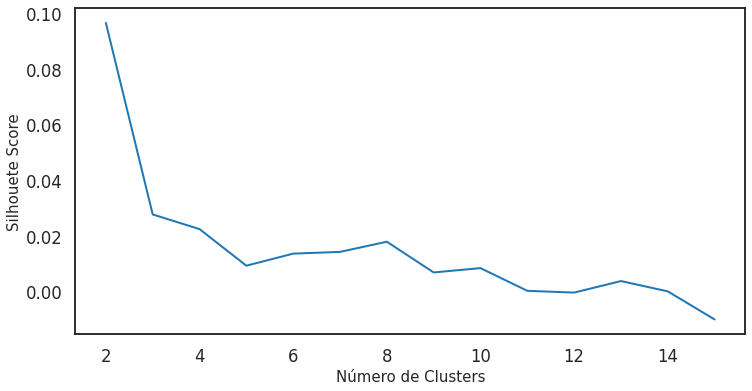

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(range(2, 16), silhouette_coef,
        linewidth=2)
ax.set_xlabel('Número de Clusters', size=15)
ax.set_ylabel('Silhouete Score', size=15)

Se puede apreciar, levemente, la existencia de un máximo local para k=8. Entrenamos un modelo con k=8 y vemos como nos quedan los clusters.

In [ ]:
k_means = KMeans(n_clusters=8, n_init=300)
k_means.fit(imags_pca)

KMeans(n_init=300)

# 2. Visualizamos los resultados del Clustering

Text(0.5, 1.0, 'Clusterización de Pokémon')

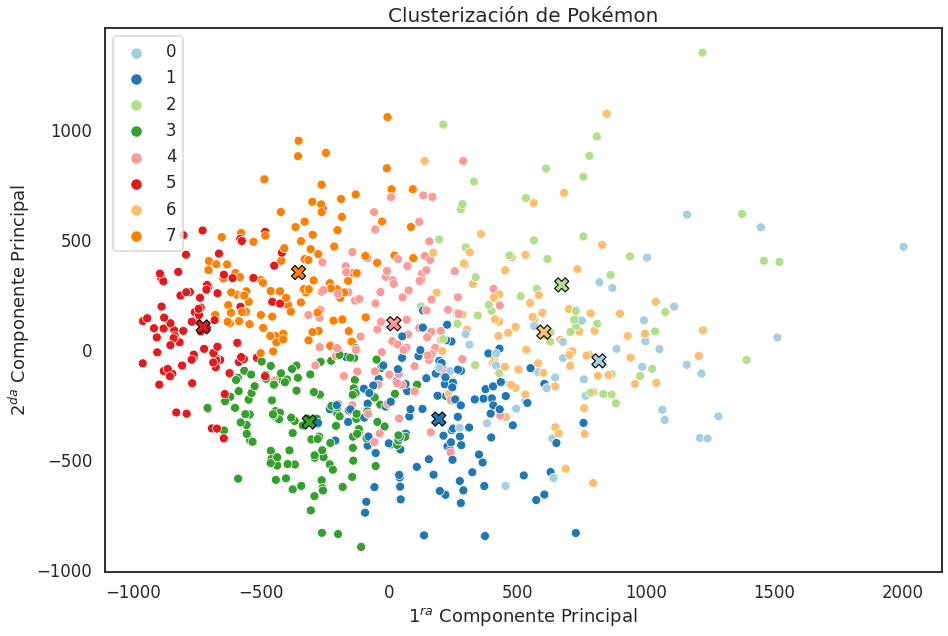

In [ ]:
import seaborn as sns

fig = plt.figure(figsize=(15, 10))

sns.set_style("white")
sns.set_context("talk")

sns.scatterplot(x=imags_pca[:, 0], y=imags_pca[:, 1], 
                hue=k_means.labels_, palette='Paired')

sns.scatterplot(x=k_means.cluster_centers_[:, 0], y=k_means.cluster_centers_[:, 1], 
                marker='X', palette='Paired', s=200, hue=np.unique(k_means.labels_),
                edgecolor='black',legend=False)

plt.xlabel(r"$1^{ra}$ Componente Principal", fontsize= 18)
plt.ylabel(r"$2^{da}$ Componente Principal", fontsize= 18)
plt.title("Clusterización de Pokémon", fontsize= 20)

Vemos que los clusters particionan los datos en una especie de disposición circular alrededor de un cluster central -el cluster 4- pero con bastante solapamiento, sobre todo en los clusters 2, 6 y 0. Con esto último se debe tener en cuenta que el gráfico solo muestra la proyeccion de los datos en las dos primeras componentes principales. En un espacio de mayor dimensión -considerando más componentes principales-, los datos pueden llegar a estar más separarados.

# 3. Visualicemos elementos de cada cluster

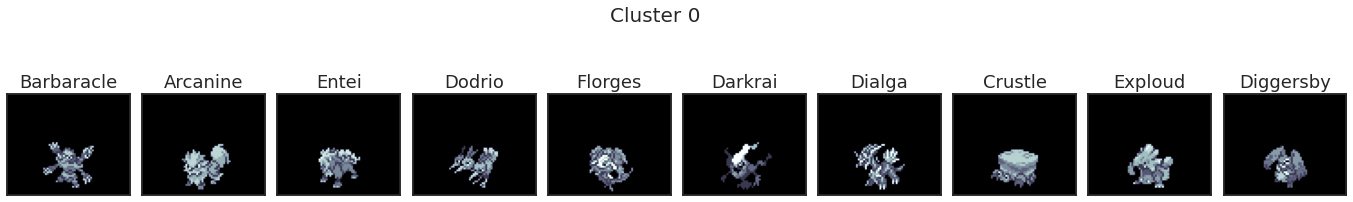

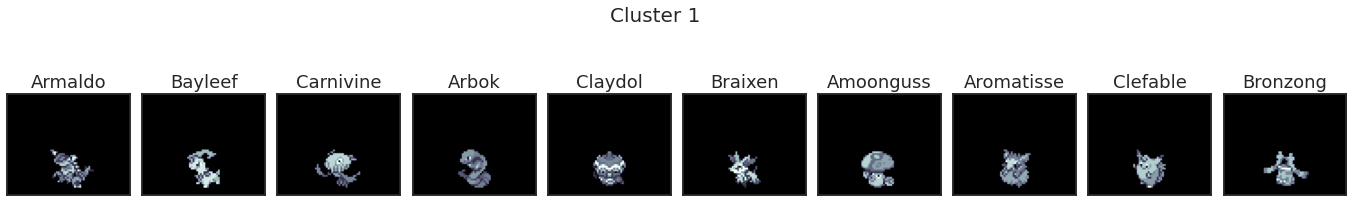

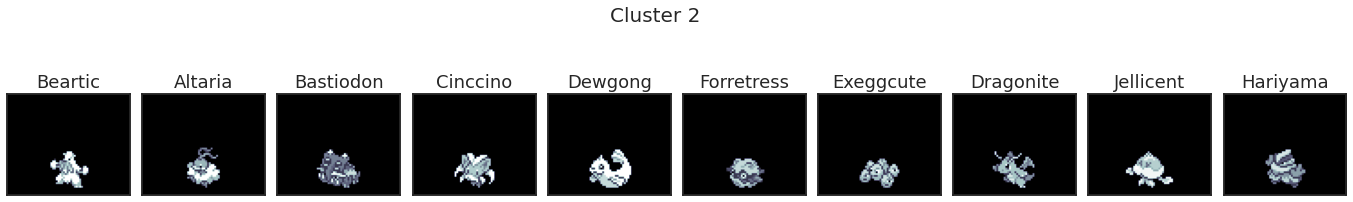

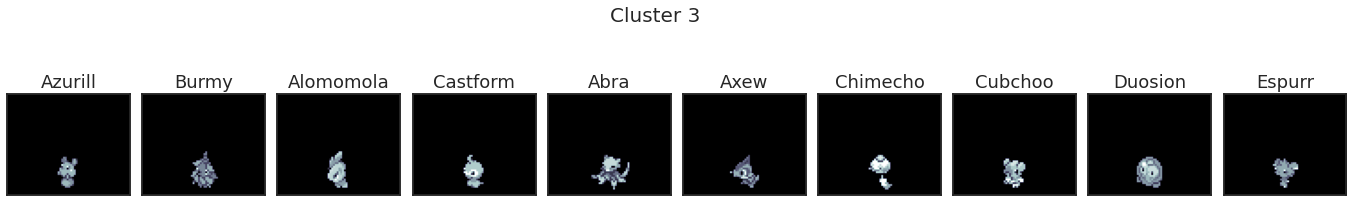

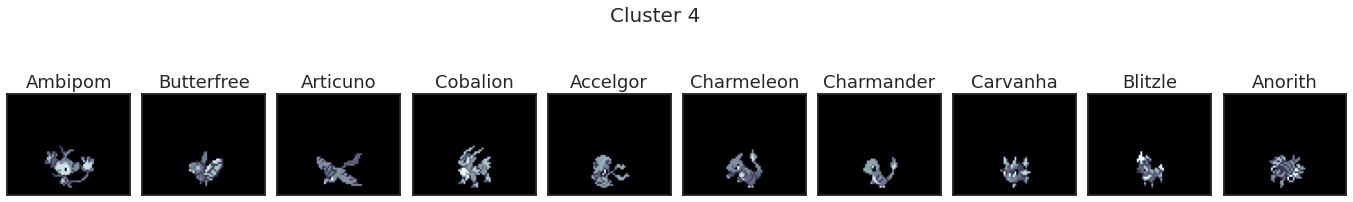

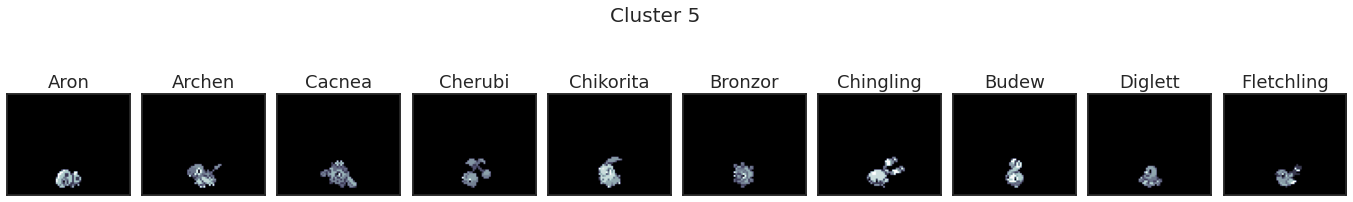

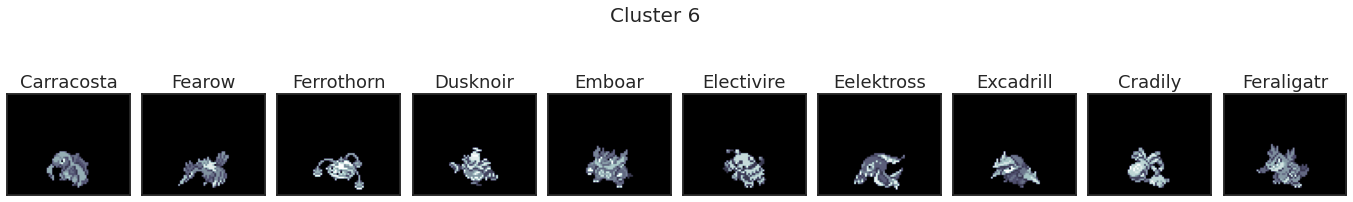

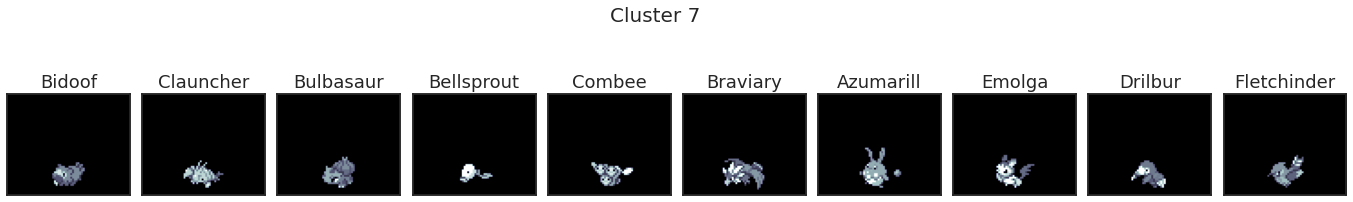

In [ ]:
# Iteramos en cada cluster
for i in range(8):
  # Identificamos los 10 primeros elementos del cluster
  idx = np.nonzero(k_means.labels_==i)[0][:10]  

  # Nos quedamos con dichos elementos                                                                                 
  first_pokemons = imags[idx]                 
  
  # Ploteamos el cluster
  fig, axes = plt.subplots(1, 10, figsize=(24, 4),
                            subplot_kw={'xticks':[], 'yticks':[]},
                            gridspec_kw=dict(hspace=0.1, wspace=0.1))
  fig.suptitle("Cluster " + str(i), fontsize=20)

  for i, ax in enumerate(axes.flat):
      ax.imshow(first_pokemons[i], cmap='bone')
      ax.set_title(names[idx[i]].title(), size=18)

A primera vista, pareciera que el rasgo principal que distingue los clusters es el tamaño de los pokémons que los componen: los clusters 3 y 5 se componen de Pokémons pequeños, a diferencia del 0 o del 6. En segundo lugar, pareciera que algunos detalles particulares como la presencia de flamas -Cluster 4- o de hojas -Cluster 5- agrupan elementos en clusters. Estos últimos pueden ayudar a que los clusters contengan una mayoria de pókemons de un tipo, como ser de fuego si aparecen muchas imagenes que contienen flamas, o tipo planta en el caso de las hojas.

# 4. Análisis de atributos por cluster 

Para comenzar agregamos un nuevo feature al dataset de atributos, que sea un label del cluster al que pertenece el pokémon.

In [ ]:
df['Cluster'] = k_means.labels_
df.head() 

,Unnamed: 0,level_0,index,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Cluster,Size
0,0,0,0,1,bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,5,105
1,1,1,1,2,ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7,163
2,2,2,2,3,venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,1,227
3,3,3,4,4,charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,7,149
4,4,4,5,5,charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False,1,190


In [ ]:
# Agrupamos por cluster y calculamos la media
df_stats = df.groupby(['Cluster'])['HP', 'Attack', 'Speed', 'Defense'].mean()
df_stats = df_stats.reset_index(level=0)
df_stats

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,Cluster,HP,Attack,Speed,Defense
0,0,69.418605,70.906977,59.906977,76.930233
1,1,70.105263,76.763158,62.105263,72.605263
2,2,71.788462,72.826923,65.557692,66.384615
3,3,68.065041,73.780488,70.365854,72.951220
4,4,65.363636,73.535354,60.888889,71.545455
5,5,69.046512,79.581395,70.837209,69.348837
6,6,70.573333,74.346667,68.026667,67.933333
7,7,64.971698,74.094340,61.783019,67.726415


Visualizamos los resultados en un gráfico de barras

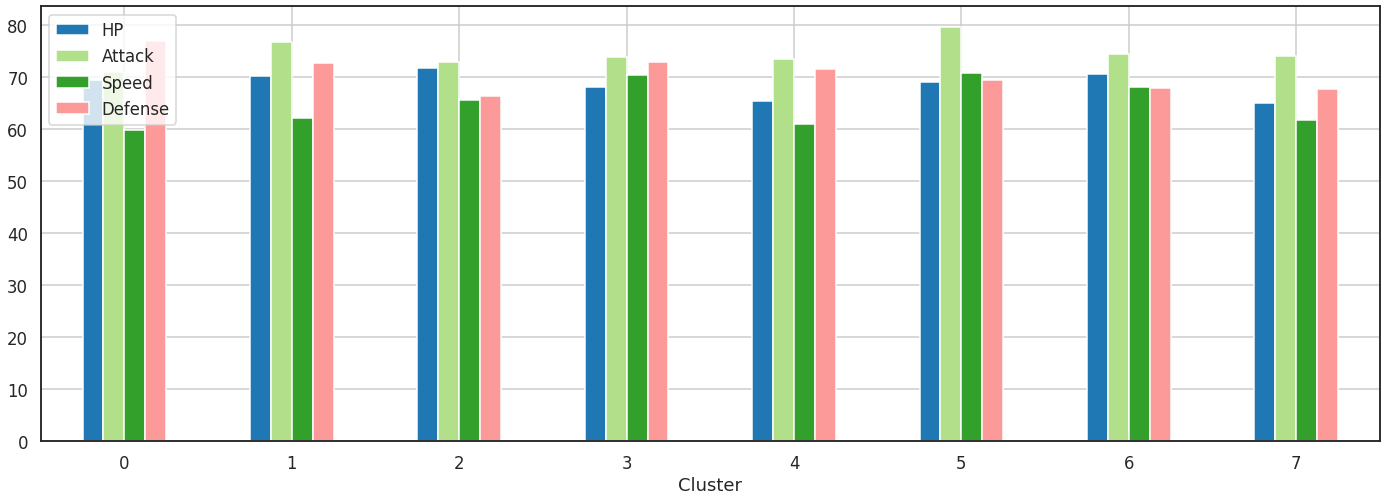

In [ ]:
# Defino una paleta de colores
colors = sns.color_palette("Paired")
df_stats.plot(x='Cluster', y=['HP', 'Attack', 'Speed', 'Defense'],
              kind='bar', figsize=(24, 8), rot=0, grid=True, color=colors[1:5])

Los resultados muestran que la distribución de atributos por cluster es a primera vista equitativa, con algún cluster que se destaca en un solo atributo, pero sin una diferencia muy significativa con el resto. 

Los cluster con más ataque son el 5 y el 1 -en ese orden-. Los clusters 4 y 7,  una distribución de atributos muy similar. 

Si tuviese que elegir el clusters más fuerte, diría que es el 5, que posee la mejor combinación de Velocidad-Ataque; o el 5 que posee la mejor combinación de Defensa-Ataque.

Otro caso que se destaca es el del cluster 0, que posee la defensa más alta, la velocidad más baja y los atributos de ataque y HP relativamente altos. Esto nos hace sospechar que es un cluster con una alta proporción de pokémons de gran tamaño. Para sacarnos la duda analicemos el tamaño de los pokémons por cluster.



# 5. Distribución de tamaños por cluster

In [ ]:
# Creamos una función que calcule el tamaño del pokemon
def poke_size(row):
  """Retorna el tamaño del pokemón 
  dada una entrada de df"""
  # Indice de la fila correspondiente
  idx = row.name

  # Tamaño del pokemon
  size = np.sum(imags[idx]!=0)

  return size


df['Size'] = df.apply(poke_size, axis=1)  
df.head()

,Unnamed: 0,level_0,index,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Cluster,Size
0,0,0,0,1,bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,5,105
1,1,1,1,2,ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,7,163
2,2,2,2,3,venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,1,227
3,3,3,4,4,charmander,Fire,NaN,309,39,52,43,60,50,65,1,False,7,149
4,4,4,5,5,charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False,1,190


Nuevamente agrupamos en clusters y calculamos valores medios

In [ ]:
# Agrupamos por cluster y calculamos la media
df_stats['Size'] = df.groupby(['Cluster'])['Size'].mean()
df_stats

,Cluster,HP,Attack,Speed,Defense,Size
0,0,69.418605,70.906977,59.906977,76.930233,309.744186
1,1,70.105263,76.763158,62.105263,72.605263,206.973684
2,2,71.788462,72.826923,65.557692,66.384615,275.750000
3,3,68.065041,73.780488,70.365854,72.951220,149.691057
4,4,65.363636,73.535354,60.888889,71.545455,198.292929
5,5,69.046512,79.581395,70.837209,69.348837,117.953488
6,6,70.573333,74.346667,68.026667,67.933333,281.333333
7,7,64.971698,74.094340,61.783019,67.726415,171.273585


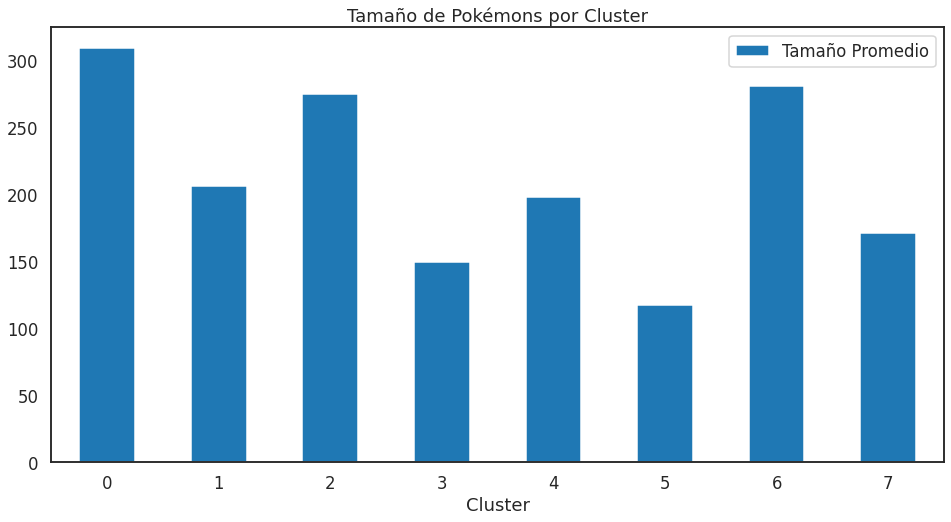

In [ ]:
df_stats.plot(x='Cluster', y=['Size'],
              kind='bar', figsize=(16, 8), 
              rot=0, color=colors[1], 
              label=['Tamaño Promedio'],
              title='Tamaño de Pokémons por Cluster')

Nuestras sospechas de que el cluster 0 posee el tamaño promedio más alto se cumplen. Además también se cumple el razonamiento contrario en donde el cluster con pokémons de menor tamaño, el 5, es el que posee mayor velocidad en promedio.

Este gráfico en conjunto con el anterior, nos demuestra los pokémons más grandes no son necesariamente los más fuertes. De hehco se cumple lo contrario: el cluster 5 es el de menor tamaño promedio pero el primer en el atributo attack.

Para finalizar con el analisis, veamos la distribución de legendarios por cluster.

# 6. Distribución de legendarios

In [ ]:
# Generamos una columna con la cantidad de legendarios por cluster
df_stats['Total Legendary'] = df.groupby(['Cluster'])['Legendary'].sum()
df_stats['Legendary Proportion'] = df.groupby(['Cluster'])['Legendary'].sum()/df.groupby(['Cluster'])['Legendary'].size()
df_stats['Non-Legendary Proportion'] = (df.groupby(['Cluster'])['Legendary'].size() - df.groupby(['Cluster'])['Legendary'].sum())/df.groupby(['Cluster'])['Legendary'].size()
df_stats.head(8)

,Cluster,HP,Attack,Speed,Defense,Size,Total Legendary,Legendary Proportion,Non-Legendary Proportion
0,0,69.418605,70.906977,59.906977,76.930233,309.744186,1,0.023256,0.976744
1,1,70.105263,76.763158,62.105263,72.605263,206.973684,8,0.070175,0.929825
2,2,71.788462,72.826923,65.557692,66.384615,275.750000,4,0.076923,0.923077
3,3,68.065041,73.780488,70.365854,72.951220,149.691057,10,0.081301,0.918699
4,4,65.363636,73.535354,60.888889,71.545455,198.292929,4,0.040404,0.959596
5,5,69.046512,79.581395,70.837209,69.348837,117.953488,3,0.034884,0.965116
6,6,70.573333,74.346667,68.026667,67.933333,281.333333,4,0.053333,0.946667
7,7,64.971698,74.094340,61.783019,67.726415,171.273585,4,0.037736,0.962264


Visualizamos el resultado en distintos gráficos de torta.

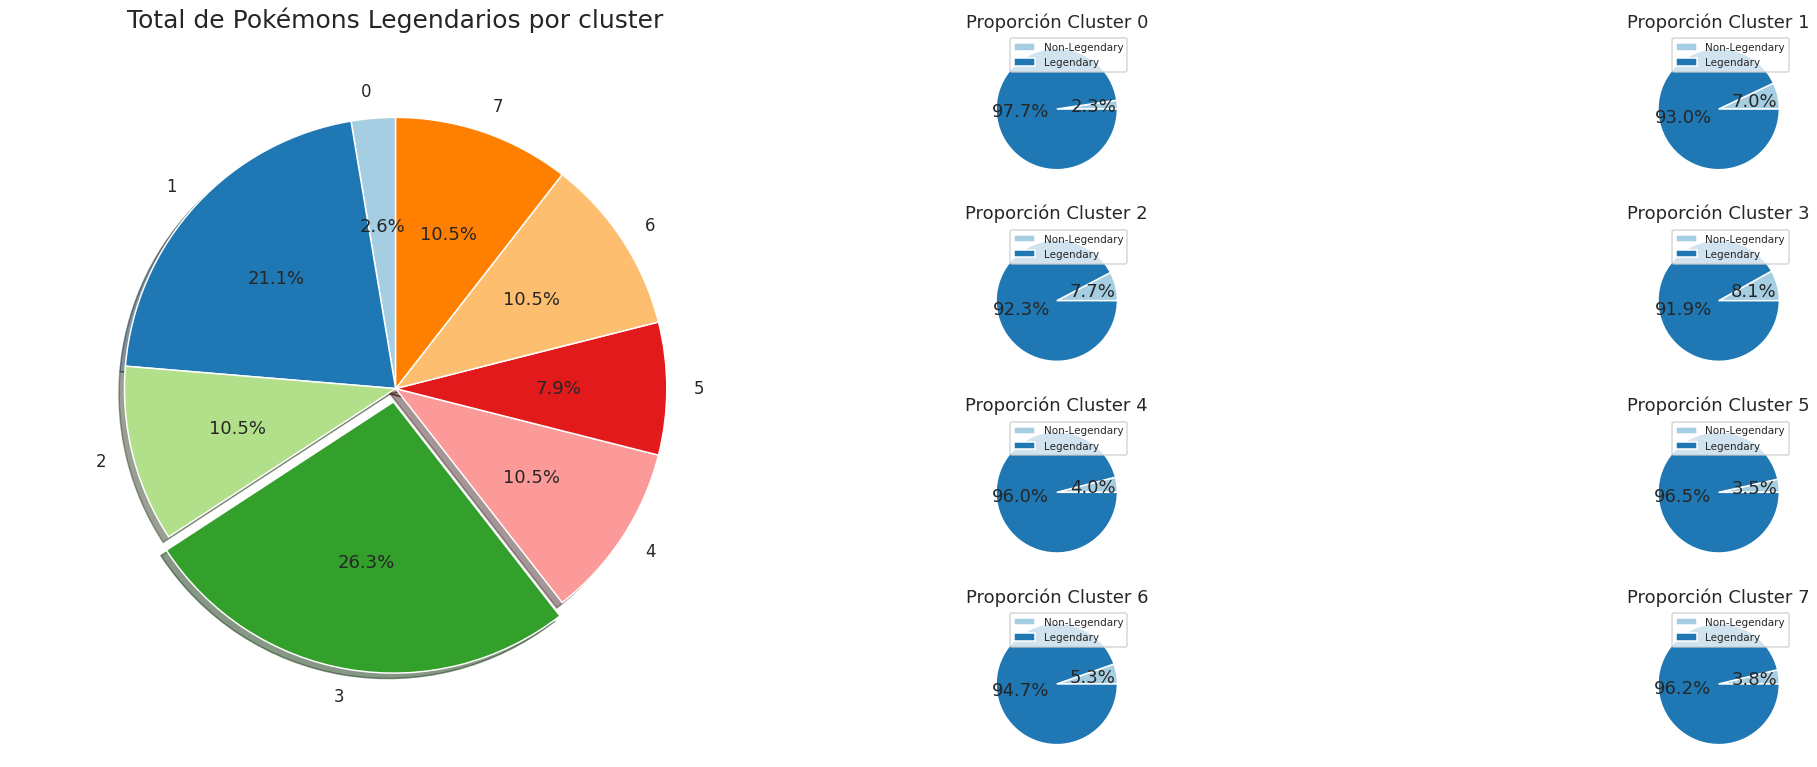

In [ ]:
from matplotlib.gridspec import GridSpec

# Kwargs de pie chart
explode = np.zeros((8,))
explode[3] = .05

# Genero una figura
fig, axs = plt.subplots(4, 3, figsize=(30, 11))
gs = axs[0, 2].get_gridspec()

# Dejo un espacio para la figura izquierda
for ax in axs[:, 0]:
    ax.remove()

# Divido en subfiguras, cada una con sus subplots
left_ax = fig.add_subplot(gs[:, 0])

# Total de Legendarios por Cluster
left_ax.pie(df_stats['Total Legendary'], labels=df_stats['Cluster'], autopct='%1.1f%%',
        shadow=True, startangle=90, explode=explode, colors=colors[0:8])
left_ax.set_title('Total de Pokémons Legendarios por cluster', size=25)
left_ax.axis('equal') 

# Genero un DataFrame cómodo para graficar
df_chart = df_stats.melt(
    value_vars=['Legendary Proportion', 'Non-Legendary Proportion'], 
    id_vars='Cluster'
    ).pivot_table(values="value", index=["Cluster","variable"])

# Proporcion de legendarios intracluster
for cluster, axs in zip(range(8), axs[:, 1:3].ravel()):
  df_chart.xs(cluster).plot(kind='pie', y="value", autopct='%1.1f%%', 
                            labels=None, ax=axs, colors=colors)
  axs.axes.get_yaxis().set_visible(False)
  axs.legend(loc=0, fontsize='xx-small', 
             labels=['Non-Legendary', 'Legendary'])
  axs.set_title(f'Proporción Cluster {cluster}')

fig.tight_layout()

En la izquierda de la figura tenemos la distribución total de Legendarios en cada Cluster. Lo primero que podemos decir es que el cluster cero es el que menor cantidad de legendarios posee, con 2,6% del total. Viendo su proporción de legendarios y no legendarios en la figura derecha -2,3%-, y recordando que dicho cluster es el de mayor tamaño promedio, podemos concluir que los Pokémons legendarios no son los de mayor tamaño.

El siguiente en proporción total e intracluster, es el cluster 5, con 7,9% del total de los legendarios y 3.5% del total de sus Pokémons. Este cluster es el de menor tamaño promedio, lo que nos lleva a concluir que los Pokémons legendarios tampoco son los de menor tamaño.

Los clusters 3 y 1 son los de mayor número de legendarios poseen, con 26.3% y 21.1% del total, respectivamente. Sus proporciones internas tambien son muy altas: el cluster 3 es de mayor proporción de legendarios sobre el total con 8.1%, mientras que el 1 es el tercero más alto con 7.0%. Estos Clusters se caracterizan por tener un tamaño medio y estadísticas de ataque y defensa altas.

Para finalizar, el cluster 2 posee la segunda proporción más alta de legendarios vs no legendarios. Aquí parecen agruparse los legendarios de mayor tamaño.

# 7. Modelo Supervisado

Vamos a tratar de predecir si un Pokémon es legendario a partir de sus _sprites_. Para ello voy a trabajar con las imagenes en su formato original, utilizando un modelo de red convolucional. 

Es probable que la cantidad de datos, y el desbalance entre cantidad de Pokémons legendarios y no legendarios, hagan que sea dificil que este modelo llegue a un mínimo y prediga correctamente las clases, pero solo por el hecho de probar un modelo complejo que no vimos en clase, hagamos el experimento.

Comencemos viendo como están distribuidas las etiquetas de Legendario.

In [ ]:
df['Legendary'].value_counts()

False    660
True      38
Name: Legendary, dtype: int64

Ya vemos que el conjunto está muy desbalanceado en dicha etiqueta, con lo cual la métrica Accuracy no nos va a decir mucho. Subsamplear con tan pocos datos no es una opción. Una opción sería hacer _data augmentation_  aplicando transfocmaciones sobre las imagenes de Pokémons legendarios para aumentar un poco su número y así balancear el conjunto. Por ahora nos vamos a conformar con entrenar con este conjunto y calcular el AUC.

Dividamos en conjuntos de entrenamiento y testeo, y normalicemos los datos.

In [ ]:
from sklearn.model_selection import train_test_split
# Normalizamos las imagenes: divido el conjunto entero por 255
X = imags

# Defino un vector de etiquetas 
y = df['Legendary']

# Separo en conjuntos de entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)
print(f'Tamaño de los datos de entrenamiento: {X_train.shape}, {y_train.shape}')
print(f'Tamaño de los datos de testeo: {X_test.shape}, {y_test.shape}')

Tamaño de los datos de entrenamiento: (488, 56, 68), (488,)
Tamaño de los datos de testeo: (210, 56, 68), (210,)


In [ ]:
# Normalizo las imagenes
X_train, X_test = X_train.astype('float32') / 255, X_test.astype('float32') / 255

# Agrego una dimensión extra al final (Necesario para la red convolucional)
X_train, X_test = np.expand_dims(X_train, axis=-1), np.expand_dims(X_test, axis=-1)

# Chequeo que las dimensiones sean las correctas
print(f'Tamaño de las imágenes de entrenamiento: {X_train.shape}')
print(f'Tamaño de los imágenes de testeo: {X_test.shape}')

Tamaño de las imágenes de entrenamiento: (488, 56, 68, 1)
Tamaño de los imágenes de testeo: (210, 56, 68, 1)


Hacemos One-Hot-Encoding sobre la variable categórica

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Pasamos las etiquetas a matrices categoricas
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Chequeo que las dimensiones sean las correctas
print(f'Tamaño de las etiquetas de entrenamiento: {y_train.shape}')
print(f'Tamaño de los imágenes de testeo: {y_test.shape}')

Tamaño de las etiquetas de entrenamiento: (488, 2)
Tamaño de los imágenes de testeo: (210, 2)


Definimos un modelo convolucional para realizar la clasificación. Vamos a utilizar la API Keras de la librería Tensorflow, que nos facilita el armado de modelos de Deep Learning. La arquitectura de la red fue tomada de es artículo https://towardsdatascience.com/convolutional-neural-networks-for-beginners-using-keras-and-tensorflow-2-c578f7b3bf25 

La misma fue modificada para recibir un imput del tamaño de los _sprites_.

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten


def make_model():
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', input_shape=(56, 68, 1)))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(128, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='sigmoid'))
  
  return model
  

Miramos la cantidad de parámetros de la red

In [ ]:
model = make_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 56, 68, 32)        320       
                                                                 
 batch_normalization_26 (Bat  (None, 56, 68, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_21 (Conv2D)          (None, 56, 68, 32)        9248      
                                                                 
 batch_normalization_27 (Bat  (None, 56, 68, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_26 (Dropout)        (None, 56, 68, 32)        0         
                                                                 
 flatten_6 (Flatten)         (None, 121856)           

Compilamos y entrenamos el modelo. Para compilar usamos como función de costo Categorical Cross-Entropy (https://en.wikipedia.org/wiki/Cross_entropy) y Accuracy como métrica.

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
            epochs = 6,
            batch_size = 8,
            validation_data=(X_test, y_test))

Epoch 1/6
61/61 [==============================] - 13s 207ms/step - loss: 0.9067 - accuracy: 0.5902 - val_loss: 0.2200 - val_accuracy: 0.9571
Epoch 2/6
61/61 [==============================] - 12s 204ms/step - loss: 0.4676 - accuracy: 0.7684 - val_loss: 0.2389 - val_accuracy: 0.9571
Epoch 3/6
61/61 [==============================] - 13s 206ms/step - loss: 0.2762 - accuracy: 0.8873 - val_loss: 0.2461 - val_accuracy: 0.9571
Epoch 4/6
61/61 [==============================] - 12s 202ms/step - loss: 0.1585 - accuracy: 0.9467 - val_loss: 0.3017 - val_accuracy: 0.9571
Epoch 5/6
61/61 [==============================] - 12s 202ms/step - loss: 0.1569 - accuracy: 0.9447 - val_loss: 0.2921 - val_accuracy: 0.9571
Epoch 6/6
61/61 [==============================] - 12s 204ms/step - loss: 0.0958 - accuracy: 0.9775 - val_loss: 0.3322 - val_accuracy: 0.9571


Como vemos en la salida del fiteo, si bien la función de costo del conjunto de entrenamiento disminiye, y su Accuracy aumenta, esto no sucede con el conjunto de teste, en donde la función de costo oscila. Esto nos indica que nuestra red no está pudiendo generalizar. Hice varias pruebas achicando la red y agregandole regularización (Dropout) pero no mejoró. La manera de solucionarlo sería tener más ejemplos con qué entrenarla. Para ver más claro este comportamiento miremos en un gráfico las funciones de costo.

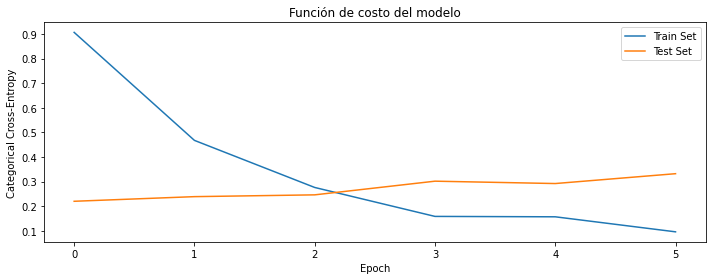

In [ ]:
# Visualizo las funciones de costo
plt.figure(figsize = (10,4))
plt.subplot(1,1,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Función de costo del modelo')
plt.ylabel('Categorical Cross-Entropy')
plt.xlabel('Epoch')
plt.legend(['Train Set', 'Test Set'])
plt.tight_layout()
plt.show()

Veamos la Accuracy para el conjunto de testeo.

In [ ]:
test_loss, test_acc = model.evaluate(X_test,  y_test)
print(f'Accuracy en el conjunto de testeo: {test_acc}')

7/7 [==============================] - 1s 180ms/step - loss: 0.2202 - accuracy: 0.9571
Accuracy en el conjunto de testeo: 0.9571428298950195


Si bien el Accuracy es alto, ya sabemos que ésto en un grupo muy desbalanceado, como el que tenemos, no indica que nuestro clasificador sea bueno. Para tener una medida real de cuán bien performa nuestro clasificador, usamos una métrica independiente del balanceo de las clases, como la curva ROC y AUC.

In [ ]:
from sklearn.metrics import roc_auc_score
y_predict = model.predict(X_test)

auc_model = roc_auc_score(y_test, y_predict, multi_class='ovr')
print(f'AUC del modelo: {auc_model}')

AUC del modelo: 0.4925373134328358


Como sospechabamos, el AUC del modelo nos dice que nuestro clasificador no es mejor que clasificar tirando una moneda. 



Se me ocurren dos problemas que pueden estar ocurriendo. El primero es que el modelo es demasiado complejo para este problema. Quizás con más tiempo y un workflow más robusto, con ajuste de hyperparámetros por ejemplo, se pueden mejorar un poco los resultados del modelo. Aún así, creo que se encontraría un techo para la mejora rapidamente, a causa del segundo problema: la escasez de datos y el desbalance del conjunto. Como dije antes, quizás se puede hacer algo con ésto último haciendo _data augmentation_. De todos modos la cantidad de datos necesaria para entrenar una red hace que sea difícil poder predecir atributos de Pokémon.